### Install liten
Must install latest tendb before running the commands
Install from released package from pypi
```bash
$ pip install -i https://test.pypi.org/simple/ liten
```
Read local setup.py and install tendb
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten
```
Install from local wheel file
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten/dist/liten-0.0.1-py3-none-any.whl
```

Import Apache arrow

In [1]:
import pyarrow as pa
from pyarrow import csv
import json
import pandas as pd

Import Liten-ten is local rten is remote. rten imports pyarrow library as well.

In [2]:
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten.lib' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


Import Ray to be used as a cluster

In [3]:
import ray

Start a cluster with single worker.

In [4]:
ray.init(num_cpus=1)

2021-10-07 16:45:06,420	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.17.205.53',
 'raylet_ip_address': '172.17.205.53',
 'redis_address': '172.17.205.53:6379',
 'object_store_address': '/tmp/ray/session_2021-10-07_16-45-05_452186_4588/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-07_16-45-05_452186_4588/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-10-07_16-45-05_452186_4588',
 'metrics_export_port': 58340,
 'node_id': '231244443aa49f8b4bad5095af7f271b35082ea7'}

In [5]:
ray.cluster_resources()

{'node:172.17.205.53': 1.0,
 'object_store_memory': 20.0,
 'CPU': 1.0,
 'memory': 60.0}

Create a Liten Cache Actor. It is residing on a remote node, and being executed on that node. tc is the Liten Cache actor handle.

In [6]:
ten.Cache = ray.remote(ten.Cache)
tc = ten.Cache.remote()

These are fact and dimension tables of TPCH. Read them remotely.

In [7]:
fact_tables = ['lineitem']
dim_tables = ['customer','orders','supplier','nation','region','partsupp','part']
tpch_dir = '/mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/'

In [8]:
def read_tables(tables, table_type):
    tc_tables = []
    for table_name in tables:
        tpch_table = tpch_dir+table_name+'.tbl'
        print('Reading ', tpch_table)
        csv_options = pa.csv.ParseOptions(delimiter='|')
        table = tc.read_csv.remote(input_file=tpch_table, parse_options=csv_options, table_name=table_name, ttype=table_type)
        # print(' Rows=', pytable.num_rows,' Cols=', pytable.num_columns)
        tc_tables.append(table)
    return tc_tables

In [9]:
%%time
fact_tables = ray.get(read_tables(fact_tables, ten.Cache.FactTable))
fact_tables

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/lineitem.tbl


(pid=4663) <frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten.lib' does not match runtime version 3.8
(pid=4663) <frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject
(pid=4663) WARNING: Logging before InitGoogleLogging() is written to STDERR
(pid=4663) I20211007 16:45:12.026883  4663 TCache.cpp:25] Created a new TCache
(pid=4663) I20211007 16:45:30.118153  4663 TCatalog.cpp:15] Created a new TCatalog


CPU times: user 1.71 s, sys: 793 ms, total: 2.51 s
Wall time: 19 s


['lineitem']

In [10]:
dim_tables = ray.get(read_tables(dim_tables, ten.Cache.DimensionTable))
dim_tables

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/customer.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/orders.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/supplier.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/nation.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/region.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/partsupp.tbl
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/part.tbl


['customer', 'orders', 'supplier', 'nation', 'region', 'partsupp', 'part']

In [11]:
ray.get(tc.info.remote())

b'{"Compute":{"WorkerThreads":6},"Table":{"part":"DimensionTable","partsupp":"DimensionTable","region":"DimensionTable","customer":"DimensionTable","lineitem":"FactTable","orders":"DimensionTable","supplier":"DimensionTable","nation":"DimensionTable"},"Schema":{"region_schema":"DimensionTable","part_schema":"DimensionTable","lineitem_schema":"FactTable","orders_schema":"DimensionTable","partsupp_schema":"DimensionTable","customer_schema":"DimensionTable","supplier_schema":"DimensionTable","nation_schema":"DimensionTable"}}'

In [12]:
pd.read_json(ray.get(tc.schema_info.remote()))

(pid=4663) I20211007 16:45:35.635040  4663 TConfigs.cpp:16] Created a new TConfigs


,Schema
customer_schema,DimensionTable
lineitem_schema,FactTable
nation_schema,DimensionTable
orders_schema,DimensionTable
part_schema,DimensionTable
partsupp_schema,DimensionTable
region_schema,DimensionTable
supplier_schema,DimensionTable


In [13]:
pd.read_json(ray.get(tc.schema_info.remote()))

,Schema
customer_schema,DimensionTable
lineitem_schema,FactTable
nation_schema,DimensionTable
orders_schema,DimensionTable
part_schema,DimensionTable
partsupp_schema,DimensionTable
region_schema,DimensionTable
supplier_schema,DimensionTable


Join all the parents and child of tensor dimensions and fact tables

In [14]:
tc.join.remote('lineitem_schema','L_ORDERKEY','orders_schema','O_ORDERKEY')
tc.join.remote('orders_schema','O_CUSTKEY','customer_schema','C_CUSTKEY')
tc.join.remote('customer_schema','C_NATIONKEY','nation_schema','N_NATIONKEY')
tc.join.remote('nation_schema','N_REGIONKEY','region_schema','R_REGIONKEY')
tc.join.remote('lineitem_schema','L_PARTKEY','partsupp_schema','PS_PARTKEY')
tc.join.remote('partsupp_schema','PS_PARTKEY','part_schema','P_PARTKEY')
tc.join.remote('partsupp_schema','PS_SUPPKEY','supplier_schema','S_SUPPKEY')

ObjectRef(be3cb809d884a562df5a1a820100000001000000)

In [15]:
def get_schemas():
    schemas = { }
    def add_schema(table_name):
        schema_name = table_name + "_schema"
        schema_info = ray.get(tc.get_schema_info.remote(schema_name))
        schemas[schema_name] = json.loads(schema_info)
    for i in range(len(fact_tables)):
        add_schema(fact_tables[i])
    for i in range(len(dim_tables)):
        add_schema(dim_tables[i])
    return schemas

In [16]:
schemas = get_schemas()
pd.DataFrame(schemas['lineitem_schema']['schema'])

,fields,name,parent,type
L_COMMENT,"{'datatype': 'string', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_COMMITDATE,"{'datatype': 'date32[day]', 'type': 'MetricFie...",lineitem_schema,NaN,FactTable
L_DISCOUNT,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_EXTENDEDPRICE,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_LINENUMBER,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_LINESTATUS,"{'datatype': 'string', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_ORDERKEY,"{'datatype': 'int64', 'type': 'DimensionField'}",lineitem_schema,"[orders_schema, O_ORDERKEY]",FactTable
L_PARTKEY,"{'datatype': 'int64', 'type': 'DimensionField'}",lineitem_schema,"[partsupp_schema, PS_PARTKEY]",FactTable
L_QUANTITY,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_RECEIPTDATE,"{'datatype': 'date32[day]', 'type': 'MetricFie...",lineitem_schema,NaN,FactTable


In [17]:
pd.DataFrame(schemas['orders_schema']['schema'])

,child,fields,name,parent,type
O_ORDERKEY,"[lineitem_schema, L_ORDERKEY]","{'datatype': 'int64', 'type': 'DimensionField'}",orders_schema,NaN,DimensionTable
O_CLERK,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_COMMENT,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_CUSTKEY,NaN,"{'datatype': 'int64', 'type': 'DimensionField'}",orders_schema,"[customer_schema, C_CUSTKEY]",DimensionTable
O_ORDERDATE,NaN,"{'datatype': 'date32[day]', 'type': 'FeatureFi...",orders_schema,NaN,DimensionTable
O_ORDERPRIORITY,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_ORDERSTATUS,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_SHIPPRIORITY,NaN,"{'datatype': 'int64', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_TOTALPRICE,NaN,"{'datatype': 'double', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable


Create remote tensor

In [18]:
%%time
ray.get(tc.make_tensor.remote())

(pid=4663) I20211007 16:45:37.573019  4663 TTable.cpp:461] Created tensor for part
(pid=4663) I20211007 16:45:43.412699  4663 TTable.cpp:461] Created tensor for partsupp
(pid=4663) I20211007 16:45:43.412885  4663 TTable.cpp:461] Created tensor for region
(pid=4663) I20211007 16:45:44.787729  4663 TTable.cpp:461] Created tensor for customer
(pid=4663) I20211007 16:46:23.420976  4663 TTable.cpp:461] Created tensor for lineitem


CPU times: user 2.74 s, sys: 896 ms, total: 3.64 s
Wall time: 51.6 s


True

Read Arrow table

(pid=4663)  TPCH QUERY 6 
(pid=4663) SELECT 
(pid=4663)   SUM(L_EXTENDEDPRICE * L_DISCOUNT) AS REVENUE 
(pid=4663) FROM 
(pid=4663)   LINEITEM
(pid=4663) WHERE
(pid=4663)   L_SHIPDATE >= DATE '1997-01-01'
(pid=4663)   AND L_SHIPDATE < DATE '1997-01-01' + INTERVAL '1' YEAR
(pid=4663)   AND L_DISCOUNT BETWEEN 0.07 - 0.01 AND 0.07 + 0.01
(pid=4663)   AND L_QUANTITY < 25;
(pid=4663) 


(pid=4663) I20211007 16:46:27.492511  4663 TTable.cpp:461] Created tensor for orders
(pid=4663) I20211007 16:46:27.492624  4663 TTable.cpp:461] Created tensor for supplier
(pid=4663) I20211007 16:46:27.492736  4663 TTable.cpp:461] Created tensor for nation
(pid=4663) I20211007 16:46:27.509291  4663 TpchDemo.cpp:98] Found table lineitem in cache
(pid=4663) I20211007 16:46:27.509393  4663 TpchDemo.cpp:98] Found table customer in cache
(pid=4663) I20211007 16:46:27.509415  4663 TpchDemo.cpp:98] Found table orders in cache
(pid=4663) I20211007 16:46:27.509430  4663 TpchDemo.cpp:98] Found table supplier in cache
(pid=4663) I20211007 16:46:27.509444  4663 TpchDemo.cpp:98] Found table nation in cache
(pid=4663) I20211007 16:46:27.509457  4663 TpchDemo.cpp:98] Found table region in cache


(pid=4663) Revenue= 156594095.60960016
(pid=4663) 
(pid=4663) Time(ms)= 276.4003
(pid=4663) 


(pid=4663) I20211007 16:46:27.785887  4663 TpchDemo.cpp:240] Completed Query6 Revenue=1.56594e+08


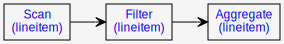

In [19]:
ray.get(tc.query6.remote())

(pid=4663) I20211007 16:46:27.909847  4663 TpchDemo.cpp:98] Found table lineitem in cache
(pid=4663) I20211007 16:46:27.909910  4663 TpchDemo.cpp:98] Found table customer in cache
(pid=4663) I20211007 16:46:27.909926  4663 TpchDemo.cpp:98] Found table orders in cache
(pid=4663) I20211007 16:46:27.909941  4663 TpchDemo.cpp:98] Found table supplier in cache
(pid=4663) I20211007 16:46:27.909957  4663 TpchDemo.cpp:98] Found table nation in cache
(pid=4663) I20211007 16:46:27.909971  4663 TpchDemo.cpp:98] Found table region in cache


(pid=4663)  
(pid=4663) SELECT
(pid=4663) 	N_NAME,
(pid=4663) 	SUM(L_EXTENDEDPRICE * (1 - L_DISCOUNT)) AS REVENUE
(pid=4663) FROM
(pid=4663) 	CUSTOMER,
(pid=4663) 	ORDERS,
(pid=4663) 	LINEITEM,
(pid=4663) 	SUPPLIER,
(pid=4663) 	NATION,
(pid=4663) 	REGION
(pid=4663) WHERE
(pid=4663) 	C_CUSTKEY = O_CUSTKEY
(pid=4663) 	AND L_ORDERKEY = O_ORDERKEY
(pid=4663) 	AND L_SUPPKEY = S_SUPPKEY
(pid=4663) 	AND C_NATIONKEY = S_NATIONKEY
(pid=4663) 	AND S_NATIONKEY = N_NATIONKEY
(pid=4663) 	AND N_REGIONKEY = R_REGIONKEY
(pid=4663) 	AND R_NAME = 'EUROPE'
(pid=4663) 	AND O_ORDERDATE >= DATE '1995-01-01'
(pid=4663) 	AND O_ORDERDATE < DATE '1995-01-01' + INTERVAL '1' YEAR
(pid=4663) GROUP BY
(pid=4663) 	N_NAME
(pid=4663) ORDER BY
(pid=4663) 	REVENUE DESC;
(pid=4663) 
(pid=4663) 
(pid=4663) Time(ms)= 5160.4204
(pid=4663) 


(pid=4663) I20211007 16:46:33.070384  4663 TpchDemo.cpp:661] Query 5 Elapsed ms=5159


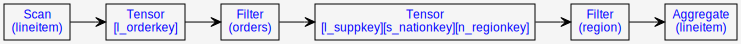

In [20]:
ray.get(tc.query5.remote())

This will kill remote Liten Cache.

In [21]:
ray.kill(tc)

Shut down ray now

In [22]:
ray.shutdown()